### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2024 Semester 2

## Assignment 1

This iPython notebook is a template which you should use for your Assignment 1 submission. This file should be submitted at the **Assignment 1: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a written report explaining your results at the **Assignment 1: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

In [204]:
# Additional code for Question 2

import numpy as np
import cv2

# Real-world heights for sample objects, in meters (m)
img_dog = 'dog.png'
h_dog = 0.4
img_statue = 'statue.png'
h_statue = 1.8
img_elephant = 'elephant.png'
h_elephant = 3.5

# Read a transparent PNG image
transparent_obj = cv2.imread('dog.png', cv2.IMREAD_UNCHANGED)
obj = transparent_obj[:,:,:3]
alpha = transparent_obj[:,:,3]

# Paste object onto background with transparency
bg = np.ones_like(obj, dtype=np.uint8) * 255
alpha = np.tile(alpha[:,:,np.newaxis], (1,1,3)).astype(np.float32) / 255.0
pasted_object = (obj.astype(np.float32) * alpha) + (bg.astype(np.float32) * (1-alpha))
pasted_object = pasted_object.astype(np.uint8)

### 1. Image filtering

In [205]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [206]:
def FFT_image_log(img):
    # Fourier transform
    f = np.fft.fft2(img)
    # Shift the low frequency component to the center
    f = np.fft.fftshift(f)
    
    # Fourier phase and magnitude
    phase = np.angle(f)
    magnitude = np.abs(f)
    
    # The orginal magnitute is too small, taking log magnitude to make it clearer
    magnitude_log = np.log(np.abs(f))  
    
    # Figure size
    plt.subplots(figsize=(7, 7)) 
    plt.axis('off')

    # Original image
    plt.subplot(2,2,1)
    plt.imshow(img ,cmap='gray')  
    plt.title('image')
    plt.axis('off')
        
    # The orginal magnitude
    plt.subplot(2,2,2)
    plt.imshow(magnitude ,cmap='gray')  
    plt.title('magnitude')
    plt.axis('off')
    
    # Phase
    plt.subplot(2,2,3)
    plt.imshow(phase ,cmap='gray')  
    plt.title('phase')
    plt.axis('off')

    # Log of the orginal magnitude
    plt.subplot(2,2,4)
    plt.imshow(magnitude_log ,cmap='gray')  
    plt.title('log magnitude')
    plt.axis('off')

    plt.show()

/var/folders/rb/zl4f_rfd1m5dmxsq2clq5_hw0000gp/T/ipykernel_21119/4208693046.py:12: RuntimeWarning: divide by zero encountered in log
  magnitude_log = np.log(np.abs(f))


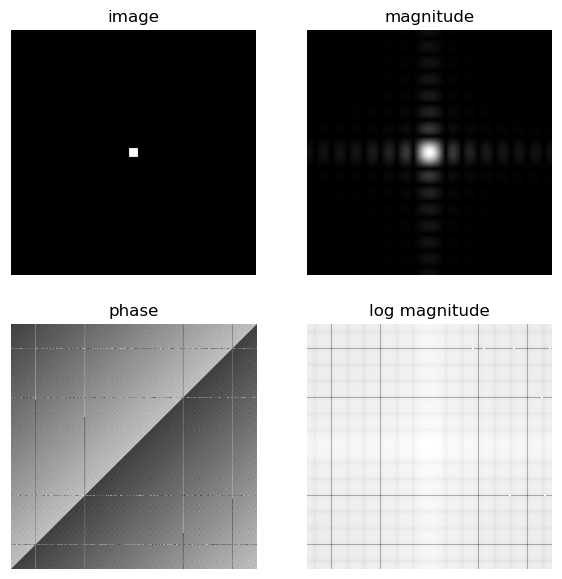

In [207]:
# create an average filter size 15x15 with values 1/225
kernel = np.ones((15,15),np.float32)/225

# pad the filter to 625x625 with 0
kernel = np.pad(kernel, ((200, 200), (200, 200)), constant_values=(0))

# take Fourior transform of the filter
FFT_image_log(kernel)

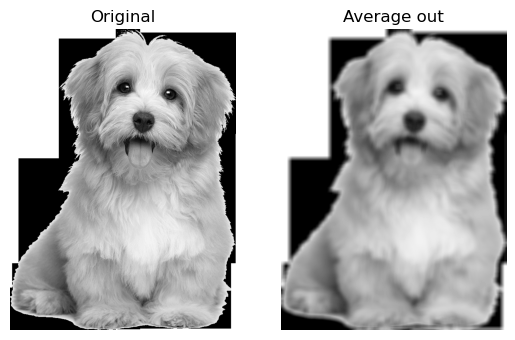

In [209]:
img = cv2.imread("dog.png",cv2.IMREAD_GRAYSCALE) 

# apply the filter on the image
avg_out = cv2.filter2D(img,-1,kernel)

plt.subplot(1,2,1)
plt.imshow(img,cmap='gray') 
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(avg_out,cmap='gray') 
plt.title('Average out')
plt.axis('off')
plt.show()

## 2. AR object rendering

In [210]:
import copy

# function to render the object on the background image
def paste_object(coords, obj_path, obj_real_height, background_img):
    # read a transparent PNG image
    transparent_obj = cv2.imread(obj_path, cv2.IMREAD_UNCHANGED)
    
    bg_height = background_img.shape[0]
    bg_width = background_img.shape[1]
    camera_height = 1.6        # the camera is located 160 cm above the ground
    f = 15                     # focal length (mm)
    z = 2                      # original distance between the background the camera (m)
    image_surface_height = 24
    
    # how many pixels the object above the ground in the background
    above_ground = bg_height - coords[0] 
    
    # get the new camera height as if the camera is in the same pixel above the ground as a
    new_height = (camera_height * above_ground)/ (bg_height/2) if above_ground != 0 else 0
    new_height = camera_height - new_height
    
    # the point the object hit on the image surface
    point = f * new_height / z 
    
    # the new distance betwen the camera and background (m)
    new_z = f * camera_height / point
    
    # object height on the background image (mm)
    yi = f * obj_real_height / new_z
    
    # convert mm to px
    yi_px = yi * bg_height / image_surface_height  
    xi_px = yi_px * transparent_obj.shape[1] / transparent_obj.shape[0]
    yi_px = int(yi_px)
    xi_px = int(xi_px)
    
    # resize the object image
    resized_obj = cv2.resize(transparent_obj, (xi_px, yi_px), interpolation = cv2.INTER_AREA)
    
    # reorder the color channels 
    obj = resized_obj[:,:,:3]
    obj_copy = copy.deepcopy(obj)
    obj[:,:,0] = obj_copy[:,:,2] #red
    obj[:,:,1] = obj_copy[:,:,1] #green
    obj[:,:,2] = obj_copy[:,:,0] #blue
    alpha = resized_obj[:,:,3]
    
    # extract part of the background
    bg = background_img[coords[0]-yi_px:coords[0], coords[1]:coords[1]+xi_px, :]
    
    # paste the object onto background with transparency
    alpha = np.tile(alpha[:,:,np.newaxis], (1,1,3)).astype(np.float32) / 255.0
    pasted_object = (obj.astype(np.float32) * alpha) + (bg.astype(np.float32) * (1-alpha))
    pasted_object = pasted_object.astype(np.uint8)
    
    # put back the object-on-background part on the original background
    background_img[coords[0]-yi_px:coords[0], coords[1]:coords[1]+xi_px, :] = pasted_object
    return background_img

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


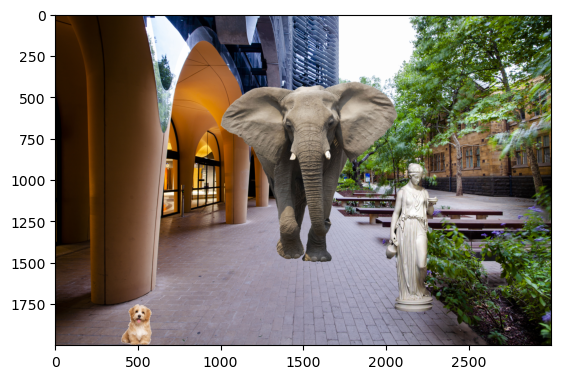

In [213]:
# load the background image
background_img = cv2.imread("background.jpg", cv2.IMREAD_UNCHANGED) 
background_img = cv2.cvtColor(background_img, cv2.COLOR_BGR2RGB)
    
background_img = paste_object((2000, 400), img_dog, h_dog, background_img)
background_img = paste_object((1800, 2000), img_statue, h_statue, background_img)
background_img = paste_object((1500, 1000), img_elephant, h_elephant, background_img)
plt.imshow(background_img)